In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import interpolate
plt.rc('font',family='Times New Roman')

In [2]:
probe_folder="../postProcessing/probes/200"
sampling_folder="../postProcessing/singleGraph/200"
lb_folder="./LB/"

## validate the obstacle center temperature

In [3]:
center_T_ref=[4.248,6.193,7.132,7.715,7.571]
center_T_ref=[T/100 for T in center_T_ref]
center_T_ref

[0.042480000000000004, 0.06193, 0.07132, 0.07715, 0.07571]

In [4]:
Tfin=300
q=100
ladalf=2
H=0.02

with open(f"{probe_folder}/T","r") as fp:
    lines = fp.readlines()
    data=lines[-1]
center_T_dbs=data.strip("\n").split()
center_T_dbs.pop(0)
center_T_dbs=[(float(T)-Tfin)/(q*H/ladalf) for T in center_T_dbs]
center_T_dbs

[0.042966999999976,
 0.061598000000003594,
 0.07129800000001296,
 0.07724999999999227,
 0.07571000000001504]

In [5]:
relative_error_center_T=0
for i in np.arange(0,5):
    error=(center_T_dbs[i]-center_T_ref[i])/center_T_ref[i]
    relative_error_center_T+=pow(error,2)
relative_error_center_T=math.sqrt(relative_error_center_T)/len(center_T_dbs)
print(f"relative_error_center_T: {relative_error_center_T*100}%")

relative_error_center_T: 0.2545134076010436%


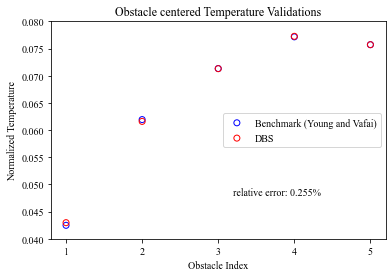

In [6]:
indexs=np.arange(1,6)
fig, ax = plt.subplots()
ax.scatter(indexs,center_T_ref, c='none',marker='o', edgecolors='b',label="Benchmark (Young and Vafai)" )
ax.scatter(indexs,center_T_dbs, c='none',marker='o', edgecolors='r',label="DBS" )
ax.set_xticks(indexs)
ax.set_ylim([0.04,0.08])
ax.set_xlabel("Obstacle Index")
ax.set_ylabel("Normalized Temperature")
ax.set_title("Obstacle centered Temperature Validations")
ax.text(3.2,0.048,"relative error: {:.3f}%".format(relative_error_center_T*100))
ax.legend(loc="center right")

## validate  surface temperature of obstacles (Index1 & Index2)

In [7]:

w=0.005
L=4*w

In [8]:
def read_obstacle_surface_temperature(obstacle_index):
    df_obstacle=pd.DataFrame({"distance":[],"T":[]})
    for i in np.arange(1,4):
        df=pd.read_csv(f"{sampling_folder}/obstacle{str(obstacle_index)}_{str(i)}_T.csv")
        df["distance"]=(df["distance"]+(i-1)*w)/L
        df["T"]=(df["T"]-Tfin)/(q*H/ladalf)
        df_obstacle=df_obstacle.append(df)
    df_obstacle.reset_index(drop=True) 
    return df_obstacle

In [9]:
df_obstacle_1=read_obstacle_surface_temperature(1)
df_obstacle_2=read_obstacle_surface_temperature(2)


In [10]:
def read_benchmark_data(obstacle_index,prefix):
    with open(f"{lb_folder}/{prefix}{obstacle_index}-paper.txt","r") as fp:
        lines=fp.readlines()
    distances=[]
    results=[]
    for line in lines:
        data=line.split()
        distances.append(float(data[0]))
        results.append(float(data[1]))
    df=pd.DataFrame({"distance":distances,prefix:results})
    return df

In [11]:
df_obstacle_benmark_1=read_benchmark_data(1,"T")
df_obstacle_benmark_2=read_benchmark_data(2,"T")

In [12]:
interp_f1=interpolate.interp1d(df_obstacle_1["distance"],df_obstacle_1["T"],kind="linear")
df_obstacle_dbs_1_interpolated=interp_f1(df_obstacle_benmark_1["distance"])


In [13]:
relative_error_surface_temperature1=0.0
for i in df_obstacle_benmark_1.index:
    benmark=df_obstacle_benmark_1["T"][i]
    dbs=df_obstacle_dbs_1_interpolated[i]
    error=(dbs-benmark)/benmark   
    relative_error_surface_temperature1+=pow(error,2)

relative_error_surface_temperature1=math.sqrt(relative_error_surface_temperature1)/df_obstacle_benmark_1.index.size
print(f"relative_error_surface_temperature1: {relative_error_surface_temperature1*100}%")


relative_error_surface_temperature1: 0.1572857105345987%


In [14]:
interp_f2=interpolate.interp1d(df_obstacle_2["distance"],df_obstacle_2["T"],kind="linear")
df_obstacle_dbs_2_interpolated=interp_f2(df_obstacle_benmark_2["distance"])

In [15]:
relative_error_surface_temperature2=0.0
for i in df_obstacle_benmark_2.index:
    benmark=df_obstacle_benmark_2["T"][i]
    dbs=df_obstacle_dbs_2_interpolated[i]
    error=(dbs-benmark)/benmark   
    relative_error_surface_temperature2+=pow(error,2)

relative_error_surface_temperature2=math.sqrt(relative_error_surface_temperature2)/df_obstacle_benmark_2.index.size
print(f"relative_error_surface_temperature2: {relative_error_surface_temperature2*100}%")


relative_error_surface_temperature2: 0.24638007228975678%


Text(0.5, 1.0, 'Obstacle Surface Temperature Validation')

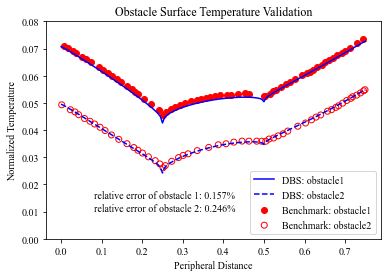

In [16]:
ax,fig=fig, ax = plt.subplots()

ax.plot(df_obstacle_2["distance"],df_obstacle_2["T"],color='b',label="DBS: obstacle1")
ax.plot(df_obstacle_1["distance"],df_obstacle_1["T"],color='b',linestyle="--",label="DBS: obstacle2")
ax.scatter(df_obstacle_benmark_2["distance"],df_obstacle_benmark_2["T"],color='r',marker="o",label="Benchmark: obstacle1")
ax.scatter(df_obstacle_benmark_1["distance"],df_obstacle_benmark_1["T"],color='',marker="o",edgecolors='r',label="Benchmark: obstacle2")
ax.set_ylim([0,0.08])
ax.legend(loc="lower right")
ax.set_xlabel("Peripheral Distance")
ax.set_ylabel("Normalized Temperature")
ax.text(0.08,0.015,"relative error of obstacle 1: {:.3f}%".format(relative_error_surface_temperature1*100))
ax.text(0.08,0.01,"relative error of obstacle 2: {:.3f}%".format(relative_error_surface_temperature2*100))
ax.set_title("Obstacle Surface Temperature Validation")

## validate  surface Nu of obstacles (Index1 & Index2)

In [17]:
def read_obstacle_surface_temperature_cell(obstacle_index,suffix):
    df_obstacle=pd.DataFrame({"distance":[],"T":[]})
    for i in np.arange(1,4):
        df=pd.read_csv(f"{sampling_folder}/obstacle{str(obstacle_index)}_{str(i)}_{suffix}.csv")
        df=df.rename( columns = {'y':'distance','x':'distance'})
        df["distance"]=(df["distance"]+(i-1)*w)/L
        df["T"]=(df["T"]-Tfin)/(q*H/ladalf)
        df_obstacle=df_obstacle.append(df)
    df_obstacle=df_obstacle.reset_index(drop=True) 
    return df_obstacle

def calculate_Nu(obstacle_index,deltax_2):
    df_cell_adj=read_obstacle_surface_temperature_cell(obstacle_index,"cell_adj_T")
    df_cell=read_obstacle_surface_temperature_cell(obstacle_index,"cell_T")
    df_nu_cell=df_cell
    df_nu_cell["nu"]=((df_cell["T"]-df_cell_adj["T"])/deltax_2)/df_cell["T"]

    return df_nu_cell



In [18]:
D=2*H #characteristic length
mesh_num=50
deltax_2=w/mesh_num/2/D
df_nu_obstacle1=calculate_Nu(1,deltax_2)
df_nu_obstacle2=calculate_Nu(2,deltax_2)
df_nu_obstacle2.tail()

,distance,T,nu
142,0.7225,0.070880,6.501129
143,0.7275,0.071311,6.663769
144,0.7325,0.071736,6.836177
145,0.7375,0.072145,6.963754
146,0.7425,0.072501,6.819216


In [19]:
df_obstacle_benmark_Nu_1=read_benchmark_data(1,"Nu")
df_obstacle_benmark_Nu_2=read_benchmark_data(2,"Nu")

In [20]:
interp_Nu_f1=interpolate.interp1d(df_nu_obstacle1["distance"],df_nu_obstacle1["nu"],kind="linear")
df_nu_obstacle_dbs_1_interpolated=interp_Nu_f1(df_obstacle_benmark_Nu_1["distance"])

relative_error_Nu1=0.0
for i in df_obstacle_benmark_Nu_1.index:
    benmark=df_obstacle_benmark_Nu_1["Nu"][i]
    dbs=df_nu_obstacle_dbs_1_interpolated[i]
    error=(dbs-benmark)/benmark   
    relative_error_Nu1+=pow(error,2)

relative_error_Nu1=math.sqrt(relative_error_Nu1)/df_obstacle_benmark_Nu_1.index.size
print(f"relative_error_Nu1: {relative_error_Nu1*100}%")


relative_error_Nu1: 8.727517348469563%


In [21]:
interp_Nu_f2=interpolate.interp1d(df_nu_obstacle2["distance"],df_nu_obstacle2["nu"],kind="linear")
df_nu_obstacle_dbs_2_interpolated=interp_Nu_f2(df_obstacle_benmark_Nu_2["distance"])

relative_error_Nu2=0.0
for i in df_obstacle_benmark_Nu_2.index:
    benmark=df_obstacle_benmark_Nu_2["Nu"][i]
    dbs=df_nu_obstacle_dbs_2_interpolated[i]
    error=(dbs-benmark)/benmark   
    relative_error_Nu2+=pow(error,2)

relative_error_Nu2=math.sqrt(relative_error_Nu2)/df_obstacle_benmark_Nu_2.index.size
print(f"relative_error_Nu2: {relative_error_Nu2*100}%")


relative_error_Nu2: 10.596551372558842%


Text(0.5, 1.0, 'Obstacle Nusselt Number Validation')

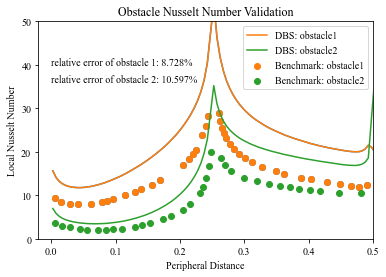

In [22]:
fig, ax = plt.subplots()
ax.plot(df_nu_obstacle1["distance"],df_nu_obstacle1["nu"],)
ax.scatter(df_obstacle_benmark_Nu_1["distance"],df_obstacle_benmark_Nu_1["Nu"])

ax.plot(df_nu_obstacle1["distance"],df_nu_obstacle1["nu"],label="DBS: obstacle1")
ax.plot(df_nu_obstacle2["distance"],df_nu_obstacle2["nu"],label="DBS: obstacle2")
ax.scatter(df_obstacle_benmark_Nu_1["distance"],df_obstacle_benmark_Nu_1["Nu"],label="Benchmark: obstacle1")
ax.scatter(df_obstacle_benmark_Nu_2["distance"],df_obstacle_benmark_Nu_2["Nu"],label="Benchmark: obstacle2")
ax.set_ylim([0,50])
ax.set_xlim([-0.02,0.5])
ax.legend()
ax.set_xlabel("Peripheral Distance")
ax.set_ylabel("Local Nusselt Number")
ax.text(0.0,40,"relative error of obstacle 1: {:.3f}%".format(relative_error_Nu1*100))
ax.text(0.0,36,"relative error of obstacle 2: {:.3f}%".format(relative_error_Nu2*100))
ax.set_title("Obstacle Nusselt Number Validation")

### Nu deviation analysis
- gradient calculation: we used the first-order difference, which may overestimate the result